<a href="https://colab.research.google.com/github/scotthou94/applied_deep_learning/blob/master/project_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Note
1. My own code starts from Generate training data

**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [0]:
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [2]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 2s (60.8 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 110377 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  57.6M      0  0:00:09  0:00:09 --:--:-- 70.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  13.6M      0  0:00:01  0:00:01 --:--:-- 13.6M


In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

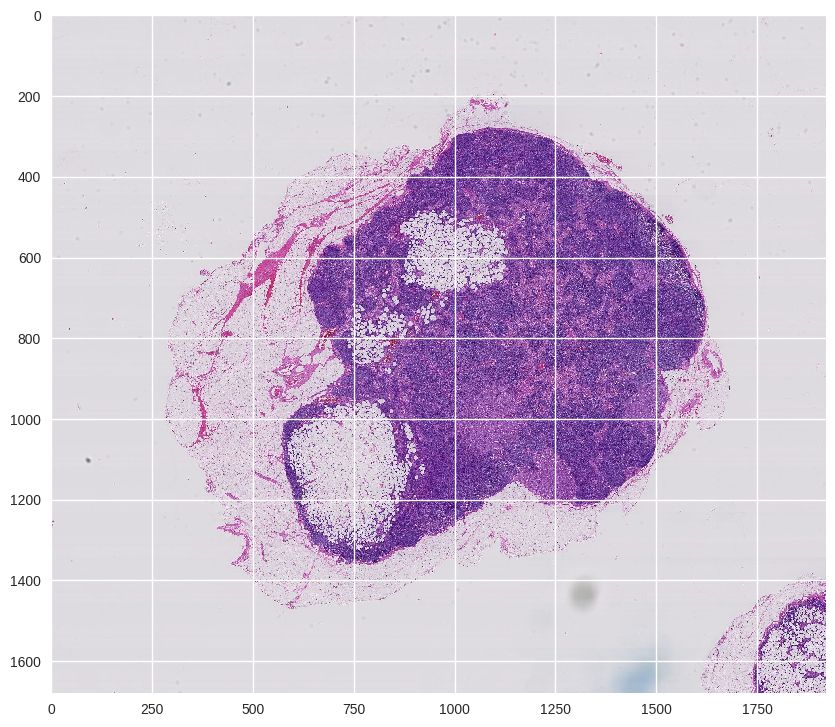

In [0]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.
level = 5
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level,
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

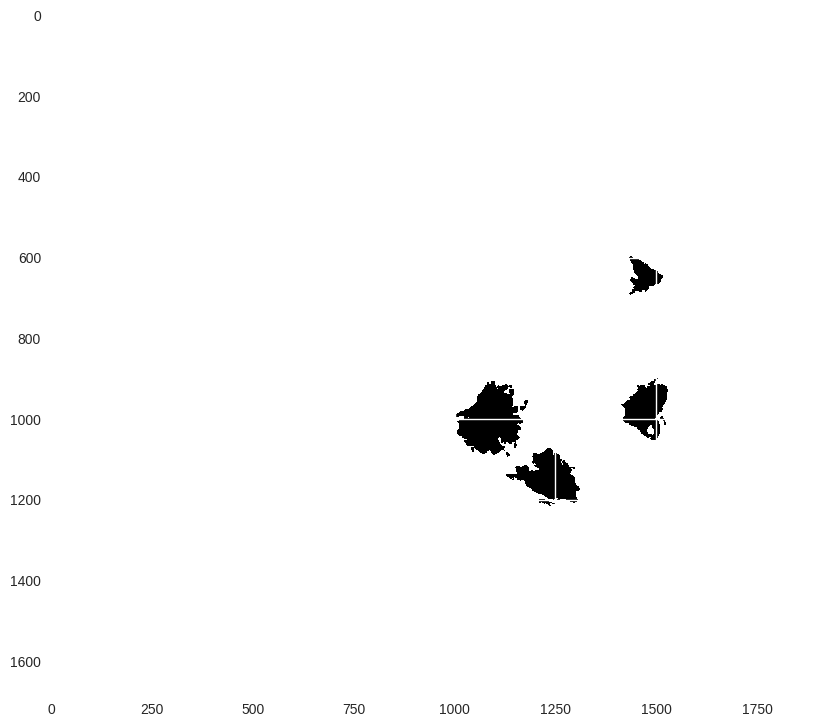

In [0]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

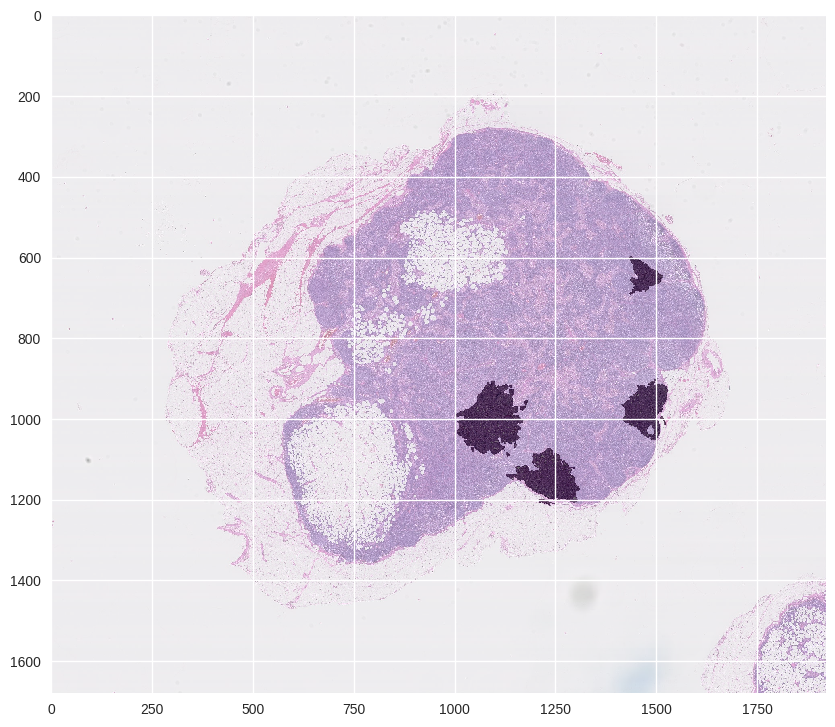

In [0]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, alpha=0.5) # Red regions contains cancer.

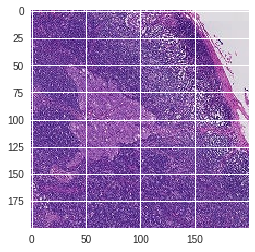

In [0]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(slide, x=1400 * 32, y=550 * 32, level=5, width=200, height=200)#[:,:,0]
plt.imshow(region)

905504 tissue_pixels pixels (28.1 percent of the image)


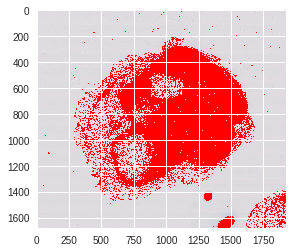

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [0]:
print(tissue_pixels[:10])

[(0, 462), (0, 463), (0, 972), (0, 973), (0, 974), (0, 975), (0, 977), (0, 978), (0, 979), (0, 980)]


### Generate training data
1. Slide across the whole slide, stride = 100
1. For each slide
    1. Save the patch, patch_size is 299 by 299
    1. Look at the center region 128 by 128 of that patch in the mask and save the label
    1. Ignore the patch if tissue_rate is lower than 0.1
    1. Ignore the patch if size is less than 299 by 299
    1. Take the patches on the edges separately

In [0]:
def get_patch_and_mask(image, mask, anchor, psize):
  assert anchor[0] < image.shape[0] and anchor[1] < image.shape[1]
  assert anchor[0] < mask.shape[0] and anchor[1] < mask.shape[1]
  region = image[anchor[0]: anchor[0] + psize, anchor[1]: anchor[1] + psize]
  msk = mask[anchor[0]: anchor[0] + psize, anchor[1]: anchor[1] + psize]
  return region, msk


def find_tissue_pixels(image, intensity=0.8):
  im_gray = rgb2gray(image)
  assert im_gray.shape == (image.shape[0], image.shape[1])
  indices = np.where(im_gray <= intensity)
  return zip(indices[0], indices[1])

# Return percentage of tissue pixels
def tissue_rate(image):
  tissue_pixels = find_tissue_pixels(image)
  total = image.shape[0] * image.shape[1]
  return len(tissue_pixels) / float(total)

# Return 1 for tumor if at least 1 pixel is cancerous
def generate_label(mask, csize):
  assert mask.shape[0] == mask.shape[1]
  W = mask.shape[0]
  start = (W - csize) / 2
  center = mask[start: start + csize, start: start + csize]
  tumor_idx = np.argwhere(center == 1)
  if len(tumor_idx) > 0:
    return 1
  else:
    return 0

In [0]:
anchor = [0, 0]  # The upper left point in a patch
stride = 100
dfactor = 32
threshold = 0.1  # tissue percentage
height, width = slide_image.shape[0], slide_image.shape[1]
psize = 299  # patch size is 299 by 299
csize = 128  # center region
print('Slide shape is {0} by {1}'.format(width, height))

x_train = []
y_train = []

total_patch = 0
while anchor[0] < height:
  while anchor[1] < width:
    patch, mask = get_patch_and_mask(slide_image, mask_image, anchor, psize)
    total_patch += 1
    tr = tissue_rate(patch)
    # Only include tissue patches and full size patch
    if tr > threshold and patch.shape == (psize, psize, 3):
      x_train.append(patch)
      label = generate_label(mask, csize)
      y_train.append(label)
      #print("Patch number {0}, tissue rate {1}".format(total_patch, tr))
    anchor[1] += stride
  anchor[1] = 0
  anchor[0] += stride

print("Total patches {0}. Valid patches {1}".format(total_patch, len(x_train)))

Slide shape is 1920 by 1680
Total patches 340. Valid patches 151


Examine our training data. Look at some cancerous patches

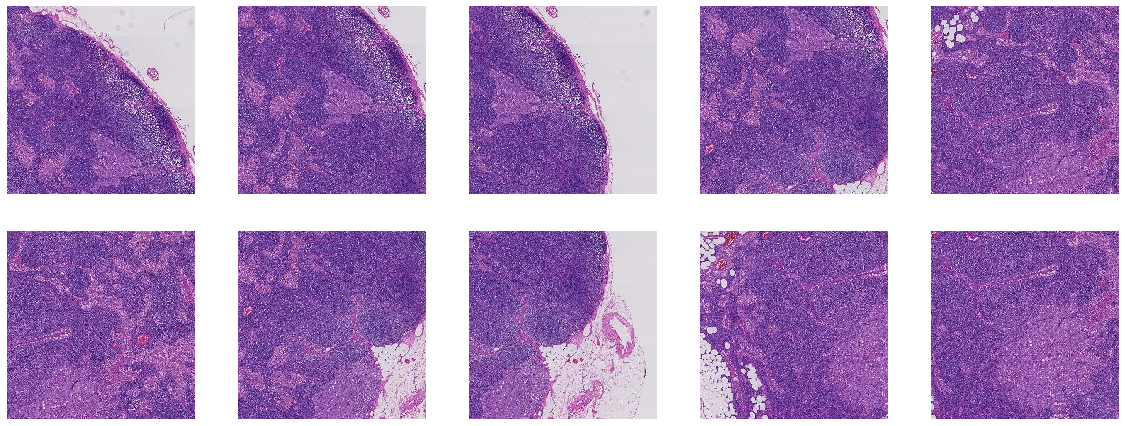

In [0]:
x_train = np.array(x_train) / 255.0
y_train = np.array(y_train)
cancer = np.argwhere(y_train == 1)
plt.figure(figsize=(20,20))
a = 0
for i in cancer[:10]:
  plt.subplot(5,5,a+1)
  a += 1
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i[0]])

Some non-cancerous patches

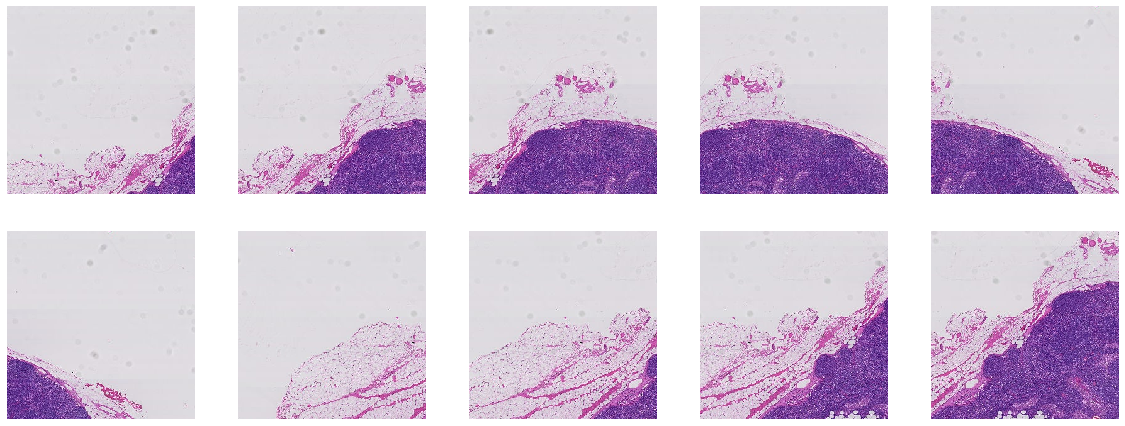

In [0]:
noncancer = np.argwhere(y_train == 0)
plt.figure(figsize=(20,20))
a = 0
for i in noncancer[:10]:
  plt.subplot(5,5,a+1)
  a += 1
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i[0]])

In [0]:
print(x_train.shape, y_train.shape)

((151, 299, 299, 3), (151,))


In [0]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(x_train, y_train)

In [0]:
print(x_train.dtype)
print(y_train.dtype)

float64
int64


### Build model using transfer learning
1. Use convolutional base from Inception V3 and add dense layer on top
1. Train on the data we just generated
1. Include loss and accuracy plot

In [0]:
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(psize,psize,3))

87924736/87910968 [==============================] - 4s 0us/step


In [0]:
model = tf.keras.models.Sequential()

model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

conv_base.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 55,357,986
Trainable params: 33,555,202
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.train.RMSPropOptimizer(learning_rate=1e-5),
              metrics=['acc'])

epochs = 10
history = model.fit(x_train,
          y_train,
          batch_size=30,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/10
4/4 [==============================] - 12s 3s/step - loss: 0.6584 - acc: 0.5833 - val_loss: 0.3916 - val_acc: 0.8065
Epoch 2/10
4/4 [==============================] - 5s 1s/step - loss: 0.6125 - acc: 0.5917 - val_loss: 0.3710 - val_acc: 0.8710
Epoch 3/10
4/4 [==============================] - 5s 1s/step - loss: 0.5688 - acc: 0.6917 - val_loss: 0.3615 - val_acc: 0.8065
Epoch 4/10
4/4 [==============================] - 5s 1s/step - loss: 0.5289 - acc: 0.7250 - val_loss: 0.3541 - val_acc: 0.8065
Epoch 5/10
4/4 [==============================] - 5s 1s/step - loss: 0.4940 - acc: 0.7583 - val_loss: 0.3527 - val_acc: 0.8387
Epoch 6/10
4/4 [==============================] - 5s 1s/step - loss: 0.4631 - acc: 0.7917 - val_loss: 0.3459 - val_acc: 0.8387
Epoch 7/10
4/4 [==============================] - 6s 1s/step - loss: 0.4349 - acc: 0.8333 - val_loss: 0.3370 - val_acc: 0.8710
Epoch 8/10
4/4 [==============================] - 5s 1s/step - loss: 0.4093 - acc: 0.8500 - val_loss: 0.3357 -

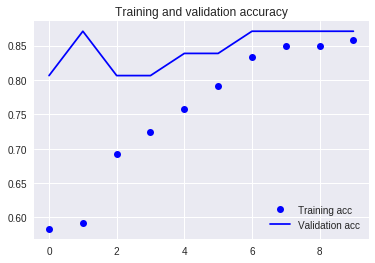

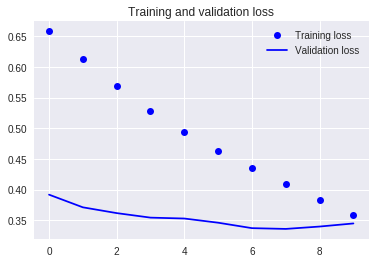

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model.save('cancer_detection_0.h5')

Upload the saved model to google cloud storage

In [0]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'tumordetection'
!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
# Make a unique bucket to which we'll upload the file.
# (GCS buckets are part of a single global namespace.)
bucket_name = 'dlproject001'

# Copy the file to our new bucket.
# Full reference: https://cloud.google.com/storage/docs/gsutil/commands/cp
!gsutil cp cancer_detection_0.h5 gs://{bucket_name}/

Copying file://cancer_detection_0.h5 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/211.7 MiB.                                    


Now that we have our model ready, we can test on a new slide
### Test
1. Load model from google cloud storage
1. Prepare a new slide and mask from google sot
1. Do the same sliding trick used on training data to produce test patches
    1. Generate the patches on the edge and throw away incomplete patches
    1. In order to generate heatmap, we need to remember the position of each patch. Save the mapping from patches to anchor position.
1. Use our model to predict on the test set
1. Generate our own predict_mask
    1. From the mapping we can figure out the area that are marked as cancerous, create a new mask from the predicts.

In [0]:
model_url = 'https://storage.googleapis.com/dlproject001/cancer_detection_0.h5'
model_path = 'cancer_detection_0.h5'

if not os.path.exists(model_path):
  !curl -O {model_path}

In [0]:
model = tf.keras.models.load_model(model_path)
model.summary()

In [0]:
tumor_test_path = 'tumor_084.tif'
mask_test_path = 'tumor_084_mask.tif'

tumor_test_url = 'https://storage.googleapis.com/dlproject001/' + tumor_test_path
mask_test_url = 'https://storage.googleapis.com/dlproject001/' + mask_test_path

if not os.path.exists(tumor_test_path):
  !curl -O $tumor_test_url
if not os.path.exists(mask_test_path):
  !curl -O $mask_test_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  799M  100  799M    0     0  52.3M      0  0:00:15  0:00:15 --:--:-- 69.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.7M  100 24.7M    0     0  22.4M      0  0:00:01  0:00:01 --:--:-- 22.4M


In [0]:
tumor_test_slide = open_slide(tumor_test_path)
mask_test_slide = open_slide(mask_test_path)

Examine the test data we're about to predict

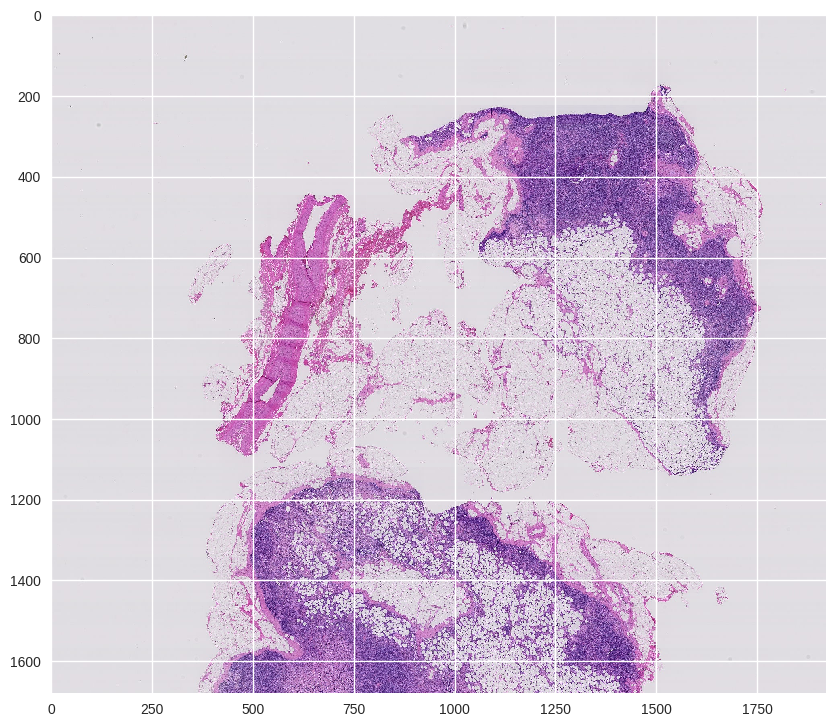

In [0]:
level = 5
test_image = read_slide(tumor_test_slide, 
                         x=0, 
                         y=0, 
                         level=level,
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(test_image)

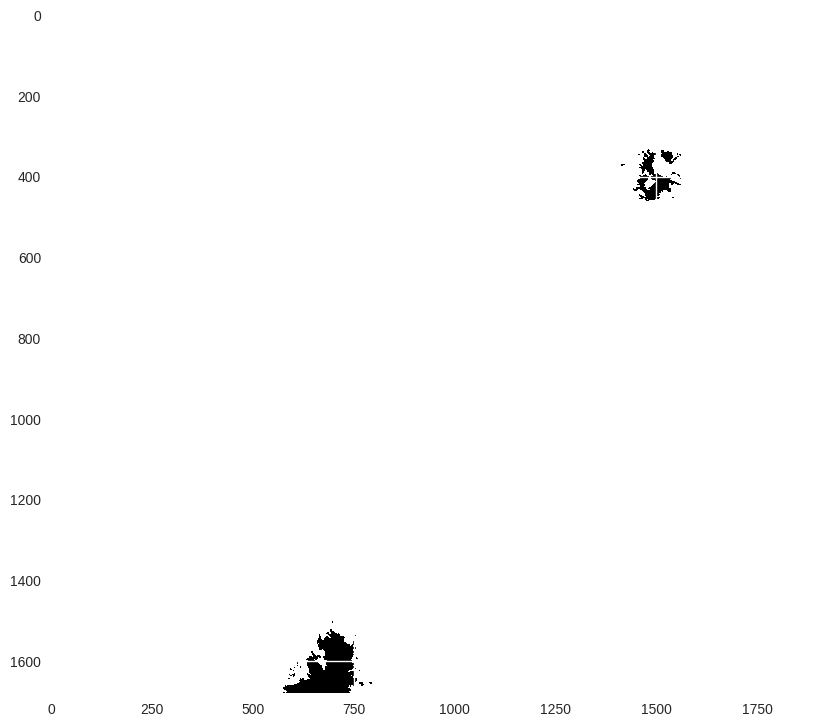

In [0]:
level = 5
mask_image = read_slide(mask_test_slide, 
                         x=0, 
                         y=0, 
                         level=level,
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

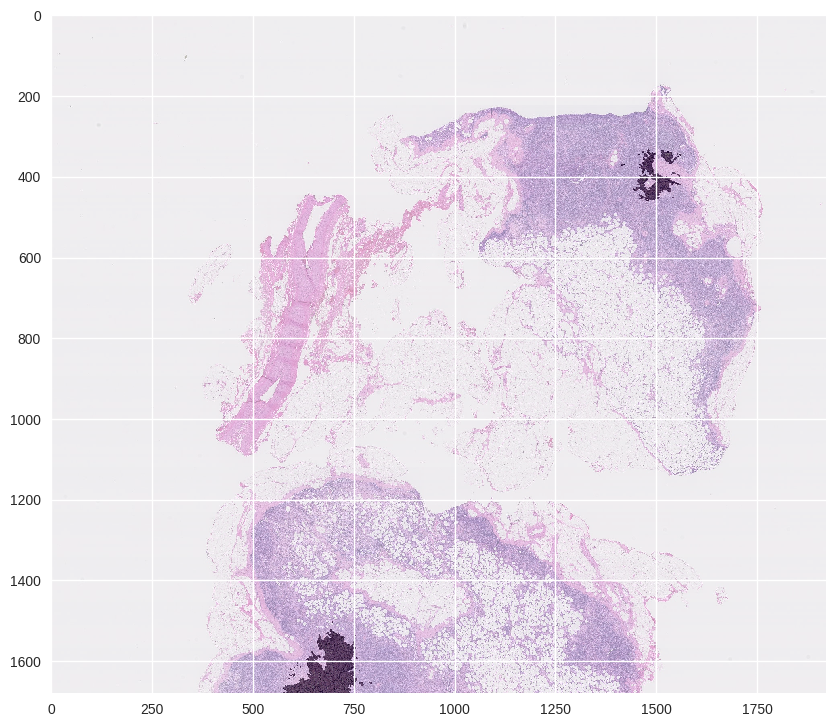

In [0]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(test_image)
plt.imshow(mask_image, alpha=0.5) # Red regions contains cancer.

Generate patches just like before. In addition, save the anchor - patch mapping

In [0]:
anchor = [0, 0]  # The upper left point in a patch
stride = 100
dfactor = 32
threshold = 0.1  # tissue percentage
height, width = slide_image.shape[0], slide_image.shape[1]
psize = 299  # patch size is 299 by 299
csize = 128  # center region
print('Slide shape is {0} by {1}'.format(width, height))

Slide shape is 1920 by 1680


In [0]:
x_test = []
y_test = []
pos = []

total_patch = 0
while anchor[0] < height:
  while anchor[1] < width:
    patch, mask = get_patch_and_mask(slide_image, mask_image, anchor, psize)
    total_patch += 1
    tr = tissue_rate(patch)
    # Only include tissue patches and full size patch
    if tr > threshold and patch.shape == (psize, psize, 3):
      x_test.append(patch)
      label = generate_label(mask, csize)
      y_test.append(label)
      pos.append([anchor[0], anchor[1]])
      #print("Patch number {0}, tissue rate {1}".format(total_patch, tr))
    anchor[1] += stride
  anchor[1] = 0
  anchor[0] += stride

print("Total patches {0}. Valid patches {1}".format(total_patch, len(x_train)))

Total patches 340. Valid patches 151


In [0]:
# Generate patches along right edges
anchor = [0, width - psize]
total = 0
valid = 0
while anchor[0] < height:
  patch, mask = get_patch_and_mask(test_image, mask_image, anchor, psize)
  total += 1
  tr = tissue_rate(patch)
  # Only include tissue patches and full size patch
  if tr > threshold and patch.shape == (psize, psize, 3):
    x_test.append(patch)
    label = generate_label(mask, csize)
    y_test.append(label)
    pos.append([anchor[0], anchor[1]])
    valid += 1
  anchor[0] += stride

print("Total right edge patches {0}. Valid patches {1}".format(total, valid))

Total right edge patches 17. Valid patches 6


In [0]:
# Generate patches along bottom edges
anchor = [height - psize, 0]
total = 0
valid = 0
while anchor[1] < width:
  patch, mask = get_patch_and_mask(test_image, mask_image, anchor, psize)
  total += 1
  tr = tissue_rate(patch)
  # Only include tissue patches and full size patch
  if tr > threshold and patch.shape == (psize, psize, 3):
    x_test.append(patch)
    label = generate_label(mask, csize)
    y_test.append(label)
    pos.append([anchor[0], anchor[1]])
    valid += 1
  anchor[1] += stride

print("Total bottom edge patches {0}. Valid patches {1}".format(total, valid))

Total bottom edge patches 20. Valid patches 13


In [0]:
x_test = np.array(x_test) / 255.0
y_test = np.array(y_test)
pos = np.array(pos)

In [0]:
np.argwhere(y_test == 1)

array([[ 13],
       [ 14],
       [ 24],
       [ 25],
       [146],
       [147],
       [160],
       [161]])

Let's see a sample patch that contains tumor cells

Predict status 0


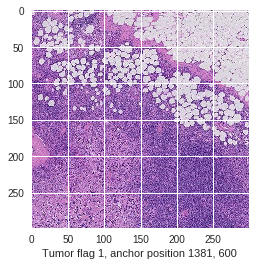

In [0]:
idx = np.argwhere(y_test == 1)[-1][0]
sample_patch = x_test[idx]
sample_label = y_test[idx]
sample_pos = pos[idx]
plt.imshow(sample_patch)
plt.xlabel("Tumor flag {0}, anchor position {1}, {2}".format(sample_label, sample_pos[0], sample_pos[1]))

p = model.predict(np.array([sample_patch]))
print("Predict status {0}".format(np.argmax(p)))


And a sample that doesn't contain tumor

Predict status 0


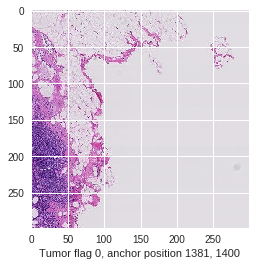

In [0]:
idx = np.argwhere(y_test == 0)[-1][0]
sample_patch = x_test[idx]
sample_label = y_test[idx]
sample_pos = pos[idx]
plt.imshow(sample_patch)
plt.xlabel("Tumor flag {0}, anchor position {1}, {2}".format(sample_label, sample_pos[0], sample_pos[1]))

p = model.predict(np.array([sample_patch]))
print("Predict status {0}".format(np.argmax(p)))

Let's first evaluate our model

In [0]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

6/6 [==============================] - 4s 681ms/step
('Test accuracy:', 0.9411764712894664)


Now that we have our test data ready, we can use our trained model to predict on each patch. Save the predict label.

In [0]:
predict = model.predict(x_test)
predict[:10]

array([[0.7337758 , 0.26622418],
       [0.974428  , 0.02557201],
       [0.9444027 , 0.05559726],
       [0.7809338 , 0.21906622],
       [0.95789135, 0.0421087 ],
       [0.83195466, 0.16804537],
       [0.7556003 , 0.24439965],
       [0.8998668 , 0.10013313],
       [0.9233981 , 0.07660189],
       [0.85634035, 0.1436597 ]], dtype=float32)

In [0]:
b = np.arange(predict.shape[0])
prob = predict[b, np.array([1])]
print(prob[:10])
print(prob.shape)
print(prob[prob > 0.5])

[0.26622418 0.02557201 0.05559726 0.21906622 0.0421087  0.16804537
 0.24439965 0.10013313 0.07660189 0.1436597 ]
(170,)
[0.5271895 0.5319255]


Use plabel together with position information, we can generate the heatmap. If a region is labeled as tumor, we generate a mask for the center 128 by 128 area in that patch

In [0]:
# Sum up the probability and total visit
def fill_mask_region(mask, anchor, psize, csize, prob):
  h = anchor[0] <= (mask.shape[0] - psize)
  w = anchor[1] <= (mask.shape[1] - psize)
  assert h and w and mask.shape[2] == 2
  starty = anchor[0] + (psize - csize) / 2
  startx = anchor[1] + (psize - csize) / 2
  visit = np.full((csize, csize, 2), [0, 1])
  probability = np.full((csize, csize, 2), [prob, 0])
  mask[starty: starty + csize, startx: startx + csize] += visit + probability

To generate heatmap, we take the mean of probability for each overlapped pixel, so each pixel is (prob_sum, visit)

In [0]:
label_info = zip(prob, pos)
h, w, channel = mask_image.shape[0], mask_image.shape[1], 2
pmask = np.full((h, w, channel), [0,0], dtype=np.float64)

for item in label_info:
  prob = item[0]
  position = item[1]
  fill_mask_region(pmask, position, psize, csize, prob)

In [0]:
# Take mean probability
pmask = np.mean(pmask, axis=2)

(1680, 1920)


Check the predict mask generated by ourselves

In [0]:
pmask.shape

(1680, 1920)

Text(0.5,1,u'ground_truth')

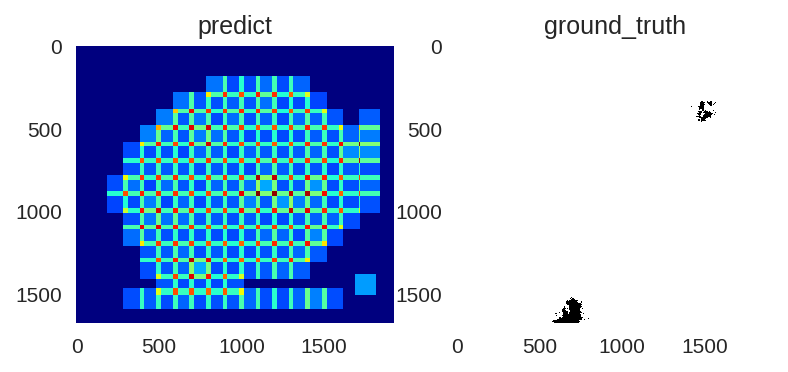

In [0]:
fig, axes = plt.subplots(1, 2, dpi=150)
axes[0].grid(False)
axes[0].imshow(pmask, cmap='jet')
axes[1].grid(False)
axes[1].imshow(mask_image)
axes[0].set_title('predict')
axes[1].set_title('ground_truth')

Now let's take the predict mask and generate a heatmap